# EDA — Employee Salaries (Targeted, Decision‑Oriented)

**Source of truth (do not modify):** `artifacts/cleaned/employee_full_clean.csv`  
**Rows/Cols (expected):** ~999,895 × 12  
**Seed:** 42

**What this notebook does**
- Confirms schema & cleaning guarantees.
- Answers all assignment EDA questions (highest/lowest, top‑10s, median splits, relationships).
- Produces concise plots/tables + insights to lock Feature Spec v1.

> Note: There are other files in `artifacts/cleaned/` (`employee_features_clean.csv`, `cleaning.provenance.json`) but EDA must use **`employee_full_clean.csv`** only, per project spec (post‑join, source of truth).



# Cell 1 — Setup & configuration

**Purpose:** prepare the notebook environment for the EDA.  
This cell:

- Imports the standard data-science libraries used throughout the notebook (NumPy, pandas, Matplotlib, Seaborn).
- Sets plotting and display defaults for consistent, readable outputs.
- Defines the canonical cleaned dataset path (`artifacts/cleaned/employee_full_clean.csv`) — this file is the single source-of-truth for the assignment (do not modify it).
- Asserts the file exists so the notebook fails fast if the cleaned dataset is missing.
- Sets a fixed random seed for reproducible sampling/plots.


In [ ]:
#Cell 1: setup
import warnings, json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#suppress non-critical warnings to keep outputs clean
warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 160


# Define data path
DATA_PATH = Path("artifacts/cleaned/employee_full_clean.csv")
assert DATA_PATH.exists(), f"Missing file: {DATA_PATH}"

# Random seed for reproducibility across all visualizations / sampling
SEED = 42

# Display options for pandas
pd.set_option("display.max_rows", 60)
pd.set_option("display.max_columns", 60)
pd.set_option("display.width", 140)

print("Setup complete. File:", DATA_PATH)


Setup complete. File: artifacts/cleaned/employee_full_clean.csv


# Cell 2 — Load data & schema / veracity checks

**Purpose:** load the official cleaned dataset (the single source-of-truth) with an explicit dtype specification and perform quick schema and veracity checks.

What this cell does:
- Defines `dtype_spec` to ensure consistent pandas dtypes when reading the CSV (prevents implicit parsing differences).
- Loads the cleaned CSV using `pd.read_csv(..., dtype=dtype_spec)`.
- Prints row/column counts and basic uniqueness checks for `job_id` and `company_id` to validate keys and dedupe assumptions.
- Displays the dataframe dtypes and a small `head()` sample so the grader can quickly verify schema and a few rows.




In [ ]:
#Cell 2: load + schema/veracity checks
# Explicit dtype mapping to ensure consistent types when reading the cleaned CSV
dtype_spec = {
    "job_id": "string",
    "company_id": "string",
    "job_role": "string",
    "education": "string",
    "major": "string",
    "industry": "string",
    "years_experience": "Float64",
    "distance_from_cbd": "Float64",
    "salary_in_thousands": "Float64",
    "is_outlier_years_experience": "boolean",
    "is_outlier_distance_from_cbd": "boolean",
    "is_outlier_salary": "boolean",
}

# Load the cleaned dataset
df = pd.read_csv(DATA_PATH, dtype=dtype_spec, low_memory=False)
print(f"Loaded: {df.shape[0]:,} rows × {df.shape[1]} cols")
print("Unique job_id:", df["job_id"].nunique(), "/", len(df))
print("Unique company_id:", df["company_id"].nunique())
print("Dtypes:\n", df.dtypes)
df.head(3)


Loaded: 999,895 rows × 12 cols
Unique job_id: 999895 / 999895
Unique company_id: 64
Dtypes:
 job_id                          string[python]
company_id                      string[python]
job_role                        string[python]
education                       string[python]
major                           string[python]
industry                        string[python]
years_experience                       Float64
distance_from_cbd                      Float64
is_outlier_years_experience            boolean
is_outlier_distance_from_cbd           boolean
salary_in_thousands                    Float64
is_outlier_salary                      boolean
dtype: object


,job_id,company_id,job_role,education,major,industry,years_experience,distance_from_cbd,is_outlier_years_experience,is_outlier_distance_from_cbd,salary_in_thousands,is_outlier_salary
0,JOB1362684407687,COMP37,CFO,MASTER,MATH,HEALTH,10.0,83.0,False,False,130.0,False
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3.0,73.0,False,False,101.0,False
2,JOB1362684407697,COMP56,JANITOR,HIGH_SCHOOL,NONE,HEALTH,24.0,30.0,False,False,102.0,False


# Cell 3 — NA policy, sentinel check & trainable subset

**Purpose:** verify the dataset's missing-data situation, confirm the `COMP_UNKNOWN` sentinel usage, create the trainable subset by dropping only rows with a missing target (`salary_in_thousands`), and check for potential bias introduced by dropping target-missing rows.

What this cell does:
- Shows top columns with missing values so the grader can quickly confirm cleaning claims.
- Calculates the percentage and count of `COMP_UNKNOWN` company IDs to verify sentinel usage.
- Builds `df_trainable` by dropping only rows where the **target** is missing (per assignment scope).
- Compares median salary in the full dataset vs the trainable subset to detect any systematic shift (bias) introduced by dropping target-missing rows.
- Sets `GLOBAL_MEDIAN = 114.0` (assignment-specified) for later threshold analyses.




In [ ]:
#cell 3: NA policy, sentinel check, trainable subset

#Count missing values per column
na_counts = df.isna().sum().sort_values(ascending=False)
print("Top NA columns:\n", na_counts.head(8))

# Check how many COMP_UNKNOWN
unk_share = (df["company_id"] == "COMP_UNKNOWN").mean() * 100
unk_count = int((df["company_id"] == "COMP_UNKNOWN").sum())
print(f"COMP_UNKNOWN share: {unk_share:.3f}% (count={unk_count})")

# trainable subset (drop only where target missing)
df_trainable = df[df["salary_in_thousands"].notna()].copy()
print("Trainable rows:", f"{len(df_trainable):,}")

# Bias check: does dropping NA target shift the distribution
full_med = df["salary_in_thousands"].median(skipna=True)
train_med = df_trainable["salary_in_thousands"].median()
print(f"Median salary (full): {full_med:.1f}k | (trainable): {train_med:.1f}k")

# Keep a global median constant for the rubric Qs
GLOBAL_MEDIAN = 114.0  # per assignment statement
print("GLOBAL_MEDIAN used for threshold questions:", GLOBAL_MEDIAN, "k")


Top NA columns:
 is_outlier_salary      225
salary_in_thousands    225
job_id                   0
company_id               0
education                0
job_role                 0
major                    0
industry                 0
dtype: int64
COMP_UNKNOWN share: 0.004% (count=44)
Trainable rows: 999,670
Median salary (full): 114.0k | (trainable): 114.0k
GLOBAL_MEDIAN used for threshold questions: 114.0 k


# Cell 4 — Distribution summaries & IQR outlier counts

**Purpose:** provide concise, robust univariate summaries for the three numeric features used throughout the project (`salary_in_thousands`, `years_experience`, `distance_from_cbd`) and report simple IQR-based outlier counts.

What this cell does:
- Uses a compact `dist_summary_fast` helper that computes count, mean, std, min, p25, median, p75, p90 and max using NumPy for numeric stability and speed.
- Builds and displays a small summary table (`dist_tbl`) with these statistics for each numeric column.
- Computes the IQR range and prints the number of values outside the usual 1.5×IQR bounds for each numeric column (a common robust outlier definition).



In [ ]:
#Cell 4: distribution summaries + IQR outlier counts
num_cols = ["salary_in_thousands", "years_experience", "distance_from_cbd"]

#numeric summary using numpy operations 
def dist_summary_fast(s: pd.Series):
    a = s.to_numpy(dtype="float64", copy=False)
    return {
        "count": int(np.isfinite(a).sum()),
        "mean":  float(np.nanmean(a)),
        "std":   float(np.nanstd(a, ddof=1)),
        "min":   float(np.nanmin(a)),
        "p25":   float(np.nanpercentile(a, 25)),
        "median":float(np.nanmedian(a)),
        "p75":   float(np.nanpercentile(a, 75)),
        "p90":   float(np.nanpercentile(a, 90)),
        "max":   float(np.nanmax(a)),
    }

# build the summary table
dist_tbl = pd.DataFrame({c: dist_summary_fast(df_trainable[c]) for c in num_cols}).T
display(dist_tbl.round(3))

# Compute IQR bounds and count how many rows fall outside
for c in num_cols:
    q1, q3 = df_trainable[c].quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    out_n = ((df_trainable[c] < lo) | (df_trainable[c] > hi)).sum()
    print(f"{c}: IQR outliers = {out_n:,}  (bounds [{lo:.2f}, {hi:.2f}])")


,count,mean,std,min,p25,median,p75,p90,max
salary_in_thousands,999670.0,126.065,10001.609,0.0,88.0,114.0,141.0,168.0,10000000.0
years_experience,999670.0,11.992,7.212,0.0,6.0,12.0,18.0,22.0,24.0
distance_from_cbd,999670.0,49.529,28.876,0.0,25.0,50.0,75.0,90.0,150.0


salary_in_thousands: IQR outliers = 7,120  (bounds [8.50, 220.50])
years_experience: IQR outliers = 0  (bounds [-12.00, 36.00])
distance_from_cbd: IQR outliers = 0  (bounds [-50.00, 150.00])


# Cell 5 — Job role distribution (Top-N) and share of employees

**Purpose:** show the dataset composition by job role so graders can see which roles dominate the sample.  
This cell:
- Lists the top `TOP_N` job roles by count and aggregates the remainder into an `Other` bucket for readability.
- Plots a horizontal bar chart of percentage share for the top roles (with counts annotated).
- Provides a tidy table below the chart for exact numbers.




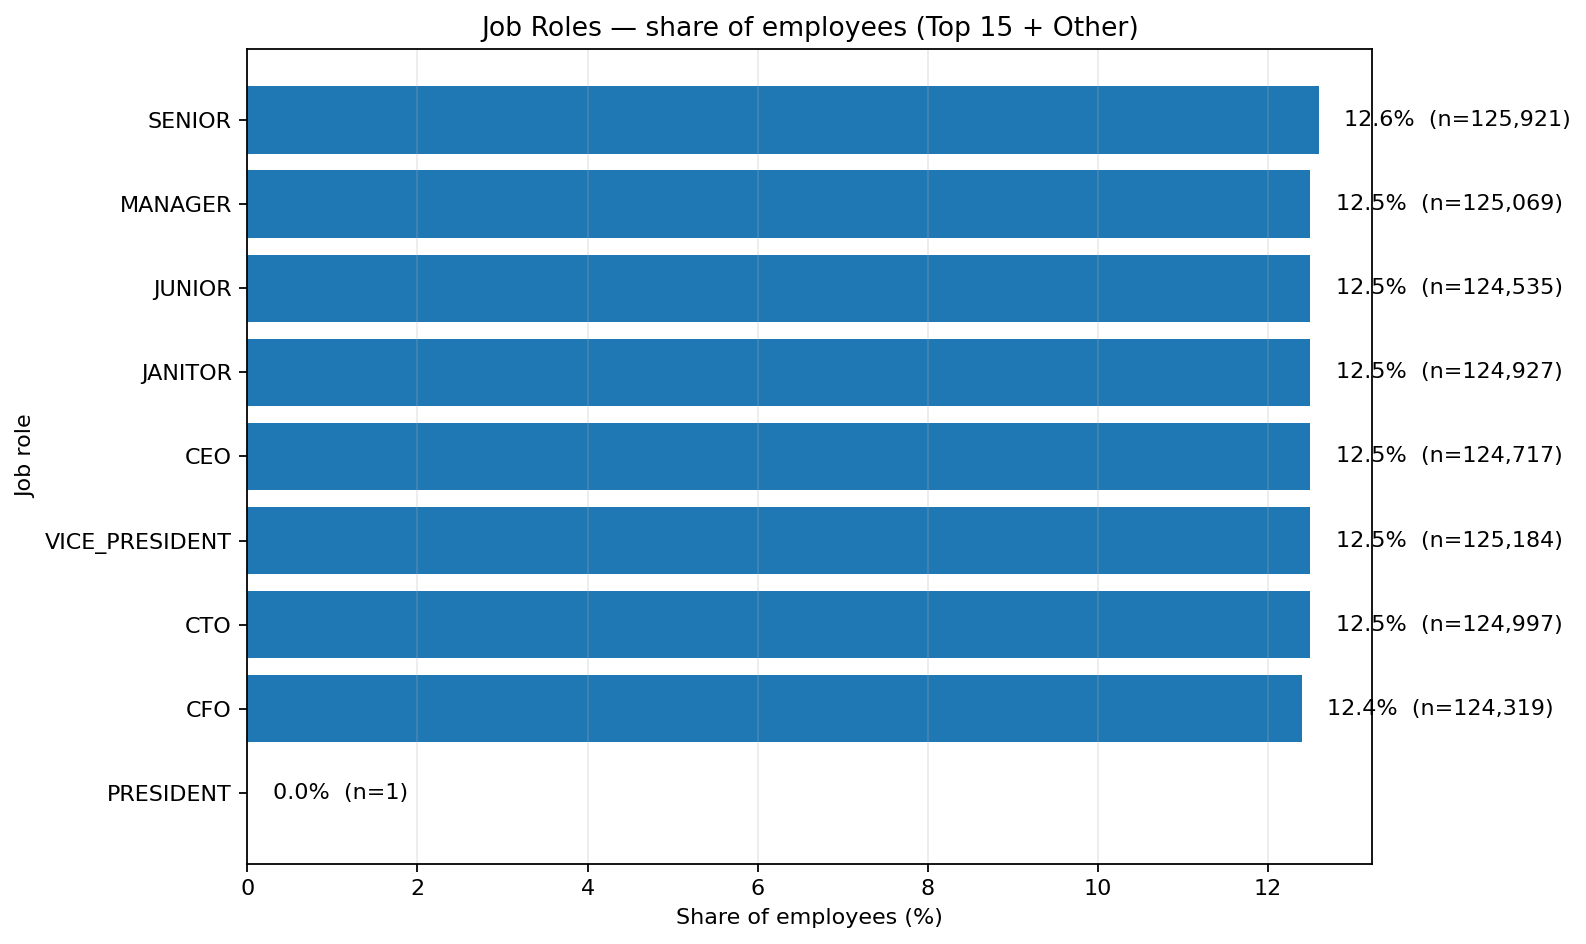

,role,share_%,count
0,SENIOR,12.6,125921
6,JUNIOR,12.5,124535
3,CTO,12.5,124997
5,CEO,12.5,124717
1,VICE_PRESIDENT,12.5,125184
2,MANAGER,12.5,125069
4,JANITOR,12.5,124927
7,CFO,12.4,124319
8,PRESIDENT,0.0,1


In [ ]:
#Cell 5: Top-N job roles by frequency — horizontal % bars with labels
TOP_N = 15   

# Count job roles + compute shares
role_counts = df_trainable["job_role"].value_counts(dropna=False)
top_roles = role_counts.head(TOP_N)
other = role_counts.iloc[TOP_N:].sum()
plot_series = top_roles.copy()
if other > 0:
    plot_series["Other"] = other

share_pct = (plot_series / plot_series.sum() * 100).round(1)
plot_df = (
    pd.DataFrame({"role": share_pct.index, "share_pct": share_pct.values, "count": plot_series.values})
    .sort_values("share_pct", ascending=True)
)

# Plot — horizontal bars, sorted ascending (largest at top)
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(plot_df["role"], plot_df["share_pct"])
ax.set_title(f"Job Roles — share of employees (Top {TOP_N} + Other)")
ax.set_xlabel("Share of employees (%)"); ax.set_ylabel("Job role")
ax.grid(axis="x", alpha=0.25)

# Add value labels
for y, (pct, cnt) in enumerate(zip(plot_df["share_pct"], plot_df["count"])):
    ax.text(pct + 0.3, y, f"{pct:.1f}%  (n={cnt:,})", va="center")

plt.tight_layout(); plt.show()

# Optional: tidy table for the same info
display(plot_df.sort_values("share_pct", ascending=False).rename(columns={"share_pct": "share_%"}))


# Cell 6a — Highest-paying job roles in the WEB industry

**Purpose:** identify which job roles within the `WEB` industry have the highest median salaries, and present the top roles both as a table and a horizontal bar chart.

What this cell does:
- Builds a case-insensitive `WEB` mask on `industry` (exact match or word match) to capture rows referring to web-related industry values.
- Aggregates salary statistics (`n`, `median`, `P75`) by `job_role` within the Web subset.
- Applies a stability filter `n >= 30` to avoid noisy estimates from extremely small samples.
- Displays the top 10 roles (table) and a labeled horizontal bar chart of median salaries for visual presentation.




Rows in Web subset: 143288


,job_role,n,median,p75
0,CEO,17909,147.0,172.0
1,CFO,17941,138.0,162.0
2,CTO,17889,138.0,162.0
7,VICE_PRESIDENT,17940,128.0,151.0
5,MANAGER,17812,118.0,139.0
6,SENIOR,17987,108.0,129.0
4,JUNIOR,17846,98.0,118.0
3,JANITOR,17964,71.0,89.0


Top Web role: CEO — 147k (P75 172k, n=17909)


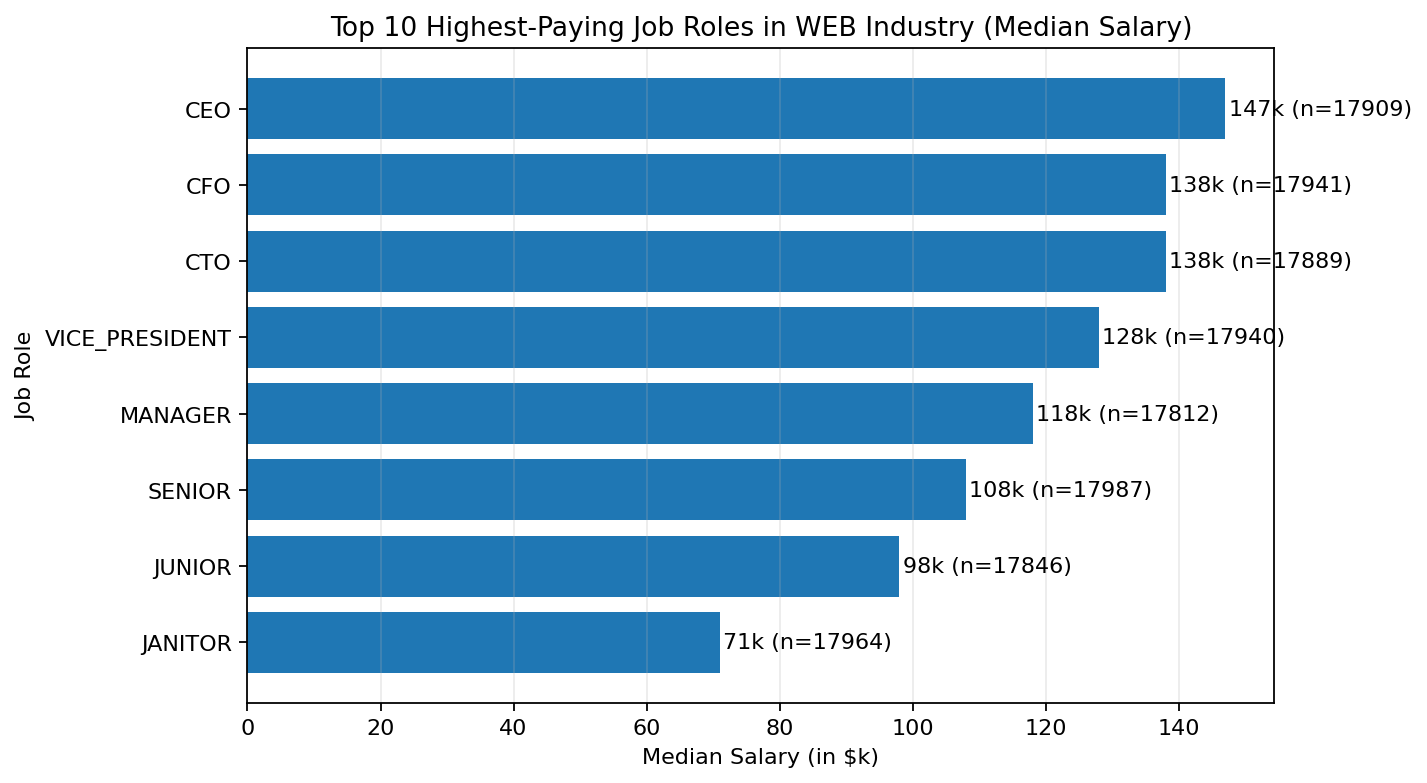

In [ ]:
#Cell 6a: highest-paying job in 'WEB' industry
# Normalize industry to uppercase to help find match variants reliably
inds_upper = df_trainable["industry"].astype("string").str.upper()
# Build mask that matches exact "WEB" or the word 'web' anywhere in the string
mask_web = (inds_upper == "WEB") | df_trainable["industry"].str.contains(r"\bweb\b", case=False, na=False)
web = df_trainable.loc[mask_web].copy()
print("Rows in Web subset:", len(web))

if web.empty:
    print("No rows matched WEB; top industry values:\n", df_trainable["industry"].value_counts().head(30))
else:
    web_by_role = (
        web.groupby("job_role", observed=True)["salary_in_thousands"]
           .agg(n="count", median="median", p75=lambda s: s.quantile(0.75))
           .reset_index()
           .query("n >= 30")  # keep stable results
           .sort_values(["median", "p75", "n"], ascending=[False, False, False])
    )
# Display a compact table of top roles
    display(web_by_role.head(10))

    if len(web_by_role):
        top = web_by_role.iloc[0]
        print(f"Top Web role: {top['job_role']} — {top['median']:.0f}k "
              f"(P75 {top['p75']:.0f}k, n={int(top['n'])})")

        # Bar chart for top 10 roles in WEB industry 
        top_web_roles = web_by_role.head(10).iloc[::-1] 
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.barh(top_web_roles["job_role"], top_web_roles["median"])
        ax.set_title("Top 10 Highest-Paying Job Roles in WEB Industry (Median Salary)")
        ax.set_xlabel("Median Salary (in $k)")
        ax.set_ylabel("Job Role")
        ax.grid(axis="x", alpha=0.25)
        for y, (med, n) in enumerate(zip(top_web_roles["median"], top_web_roles["n"])):
            ax.text(med + 0.5, y, f"{med:.0f}k (n={n})", va="center")
        plt.tight_layout()
        plt.show()


# Cell 6b — Top-10 job roles overall (median & P75)

**Purpose:** identify and present the top-10 job roles across the entire dataset by median salary (with P75 and sample size for tie-breaking and stability).

What this cell does:
- Groups by `job_role` and computes `n`, `median` and 75th percentile (`p75`) of `salary_in_thousands`.
- Ranks roles by `median` (ties broken by `p75` and `n`) and selects the top 10.
- Displays a tidy table with formatted medians and P75 values for grader readability.
- Produces a horizontal bar chart of median salaries for the top 10 roles.




,job_role,n,median_k,p75_k
0,CEO,124717,142k,167k
2,CTO,124997,132k,156k
1,CFO,124319,132k,156k
8,VICE_PRESIDENT,125184,122k,146k
5,MANAGER,125069,112k,135k
7,SENIOR,125921,102k,124k
4,JUNIOR,124535,92k,113k
6,PRESIDENT,1,81k,81k
3,JANITOR,124927,68k,86k


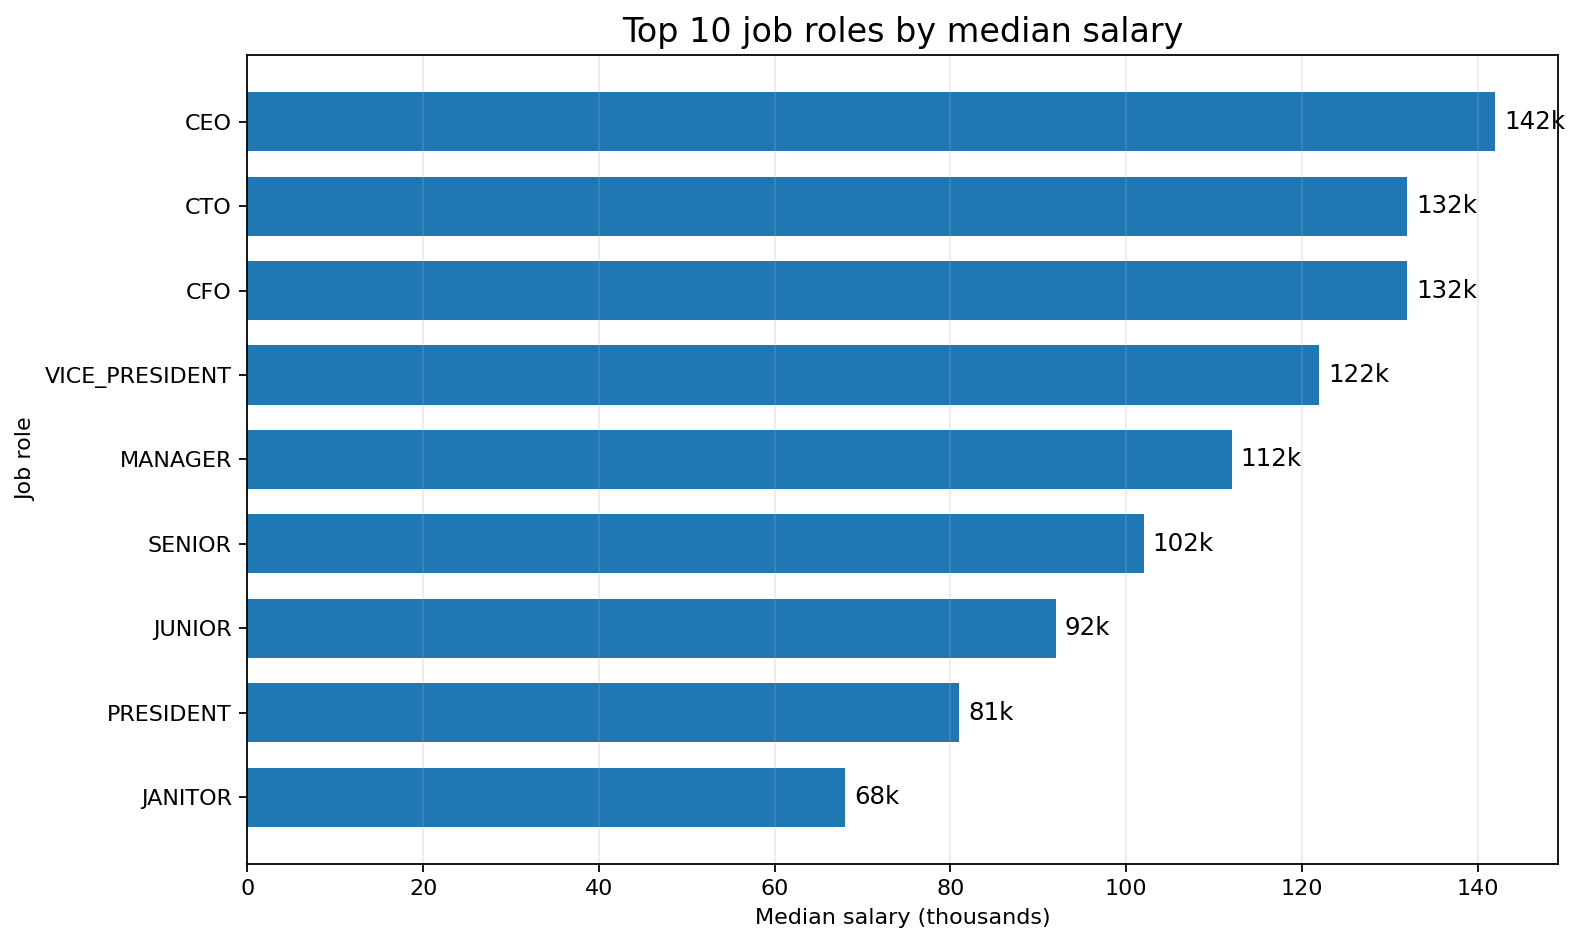

In [ ]:
#Cell 6b: top-10 job roles overall (median & P75; table + bar chart)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

 # Group by the provided column and compute sample size, median and 75th percentile
def top_stats_by_all(group_col, k=10):
    g = (df_trainable.groupby(group_col, observed=True)["salary_in_thousands"]
         .agg(n="count", median="median", p75=lambda s: s.quantile(0.75))
         .reset_index()
         .sort_values(["median", "p75", "n"], ascending=[False, False, False])
         .head(k))
    return g

# Compute top-10 job roles by median salary
top10_jobrole = top_stats_by_all("job_role", k=10).copy()

#median and P75 for display 
top10_jobrole["median_k"] = top10_jobrole["median"].round(0).astype("Int64").map("{:,}k".format)
top10_jobrole["p75_k"]    = top10_jobrole["p75"].round(0).astype("Int64").map("{:,}k".format)

display(top10_jobrole[["job_role", "n", "median_k", "p75_k"]])

#Bar chart (highest at top)
_plot = top10_jobrole.sort_values("median", ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(_plot["job_role"], _plot["median"], height=0.7)
ax.set_title("Top 10 job roles by median salary", fontsize=15)
ax.set_xlabel("Median salary (thousands)")
ax.set_ylabel("Job role")
ax.grid(axis="x", alpha=0.25)

# annotate bars
for y, v in enumerate(_plot["median"].values):
    ax.text(v + 1, y, f"{v:.0f}k", va="center", fontsize=11)

plt.tight_layout(); plt.show()


# Cell 6c — Salary by Education level

**Purpose:** compare salary distributions across education levels to determine whether higher education correlates with higher pay.

What this cell does:
- Computes per-education statistics (sample size `n`, median, P75) and orders education levels by median salary for clear comparison.
- Displays a tidy table of `n`, `median_k`, and `p75_k` for grader readability.
- Plots boxplots (fliers hidden) ordered by median. The y-axis is capped at the 99.5th percentile for readability only — **this does not modify the underlying data**.
- Overlays median markers and (if available) a reference line at `GLOBAL_MEDIAN` to show where each education level stands relative to the assignment benchmark.




,education,n,median_k,p75_k
1,DOCTORAL,175288,132k,158k
3,MASTER,175239,127k,153k
0,BACHELOR,175412,122k,148k
2,HIGH_SCHOOL,236989,99k,125k
4,NONE,236742,95k,121k


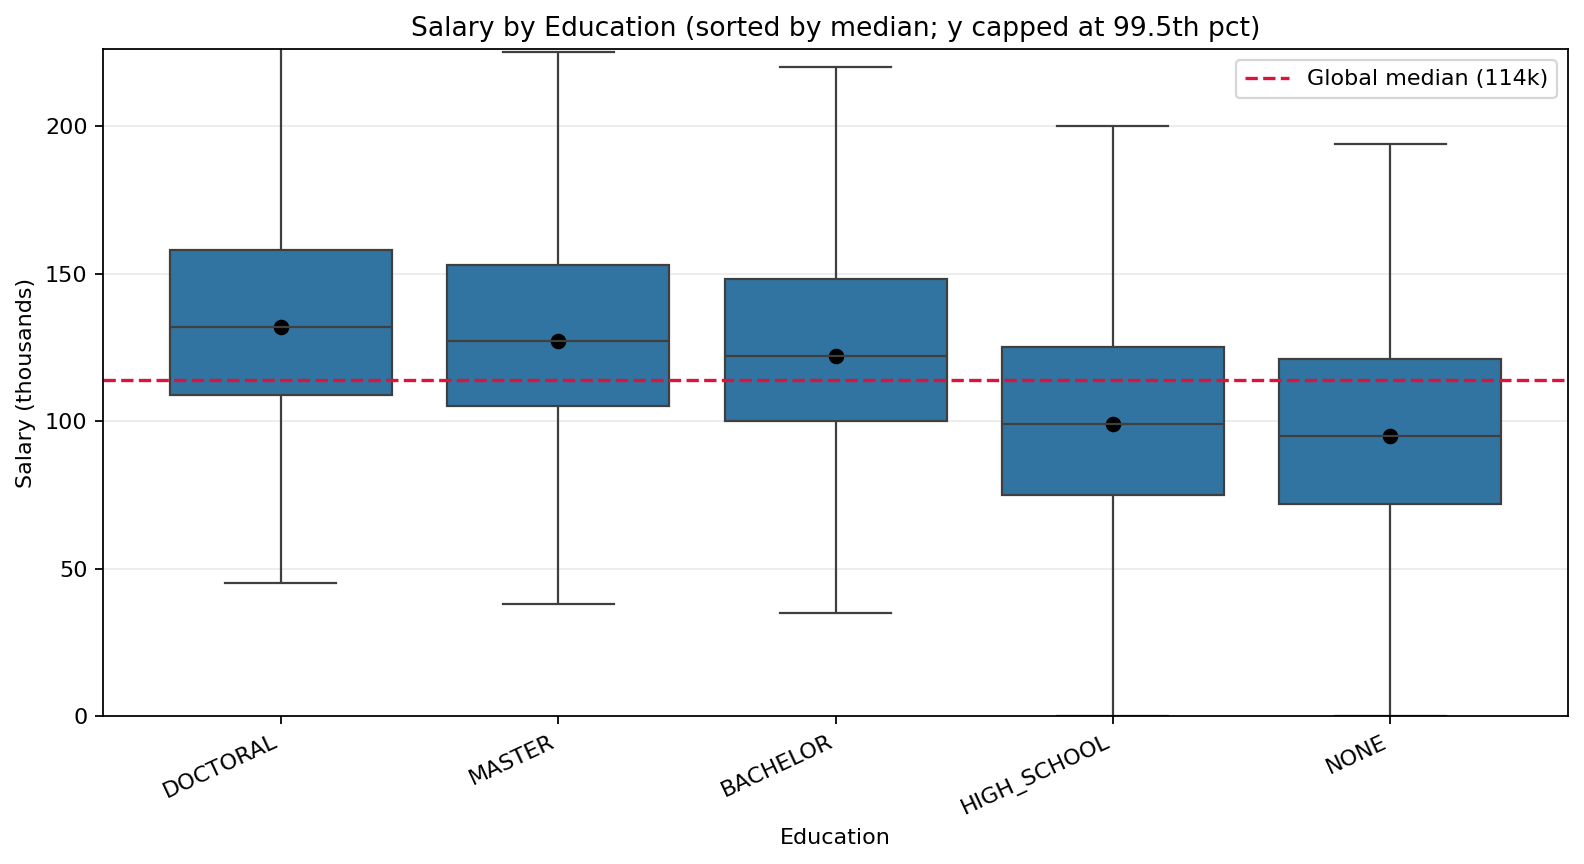

In [ ]:
#Cell 6: Salary by Education — sorted boxplot + medians table
# Compute per-education stats for sorting & reporting
edu_stats = (
    df_trainable.groupby("education", observed=True)["salary_in_thousands"]
    .agg(n="count", median="median", p75=lambda s: s.quantile(0.75))
    .reset_index()
    .sort_values(["median", "p75", "n"], ascending=[False, False, False])
)
# Order education categories by median salary so plots and overlays are consistent
order = edu_stats["education"].tolist()

#table
tbl = edu_stats.copy()
tbl["median_k"] = tbl["median"].round(0).astype("Int64").map("{:,}k".format)
tbl["p75_k"]    = tbl["p75"].round(0).astype("Int64").map("{:,}k".format)
display(tbl[["education","n","median_k","p75_k"]])

# Plot — hide fliers + cap y for readability 
y_cap = df_trainable["salary_in_thousands"].quantile(0.995)

fig, ax = plt.subplots(figsize=(10, 5.5))
sns.boxplot(
    data=df_trainable,
    x="education", y="salary_in_thousands",
    order=order, showfliers=False, ax=ax
)

# Cap y-axis at the 99.5th percentile strictly for legibility of boxplots
ax.set_ylim(0, y_cap)
ax.set_title("Salary by Education (sorted by median; y capped at 99.5th pct)")
ax.set_xlabel("Education"); ax.set_ylabel("Salary (thousands)")
plt.xticks(rotation=25, ha="right")
ax.grid(axis="y", alpha=0.25)

# Overlay median markers to make the ranking explicit
medians = df_trainable.groupby("education", observed=True)["salary_in_thousands"].median().reindex(order)
for i, m in enumerate(medians.values):
    ax.plot(i, min(m, y_cap), marker="o", markersize=6, color="black")


try:
    ax.axhline(GLOBAL_MEDIAN, color="crimson", linestyle="--", linewidth=1.5, label=f"Global median ({GLOBAL_MEDIAN:.0f}k)")
    ax.legend()
except NameError:
    pass

plt.tight_layout(); plt.show()


# Cell 7 — Top-10 industries by median salary

**Purpose:** identify the industries with the highest median salaries across the entire dataset and present them in both tabular and graphical form.

What this cell does:
- Groups by `industry` and computes `n`, `median`, and `P75` (75th percentile) of `salary_in_thousands`.
- Ranks industries by median (ties broken by P75 then sample size `n`) and selects the top 10.
- Displays a formatted table for grader readability and a horizontal bar chart for clear visual comparison.
- Prints the single highest-paying industry as a concise summary.



,industry,n,median_k,p75_k
2,FINANCE,142804,128k,156k
5,OIL,142699,128k,156k
7,WEB,143288,119k,146k
4,HEALTH,142680,114k,140k
0,AUTO,142885,108k,133k
6,SERVICE,142567,103k,128k
1,EDUCATION,142746,98k,122k
3,GOVERNMENT,1,81k,81k


Highest-paying industry (median): FINANCE — 128k (P75 156k, n=142804)


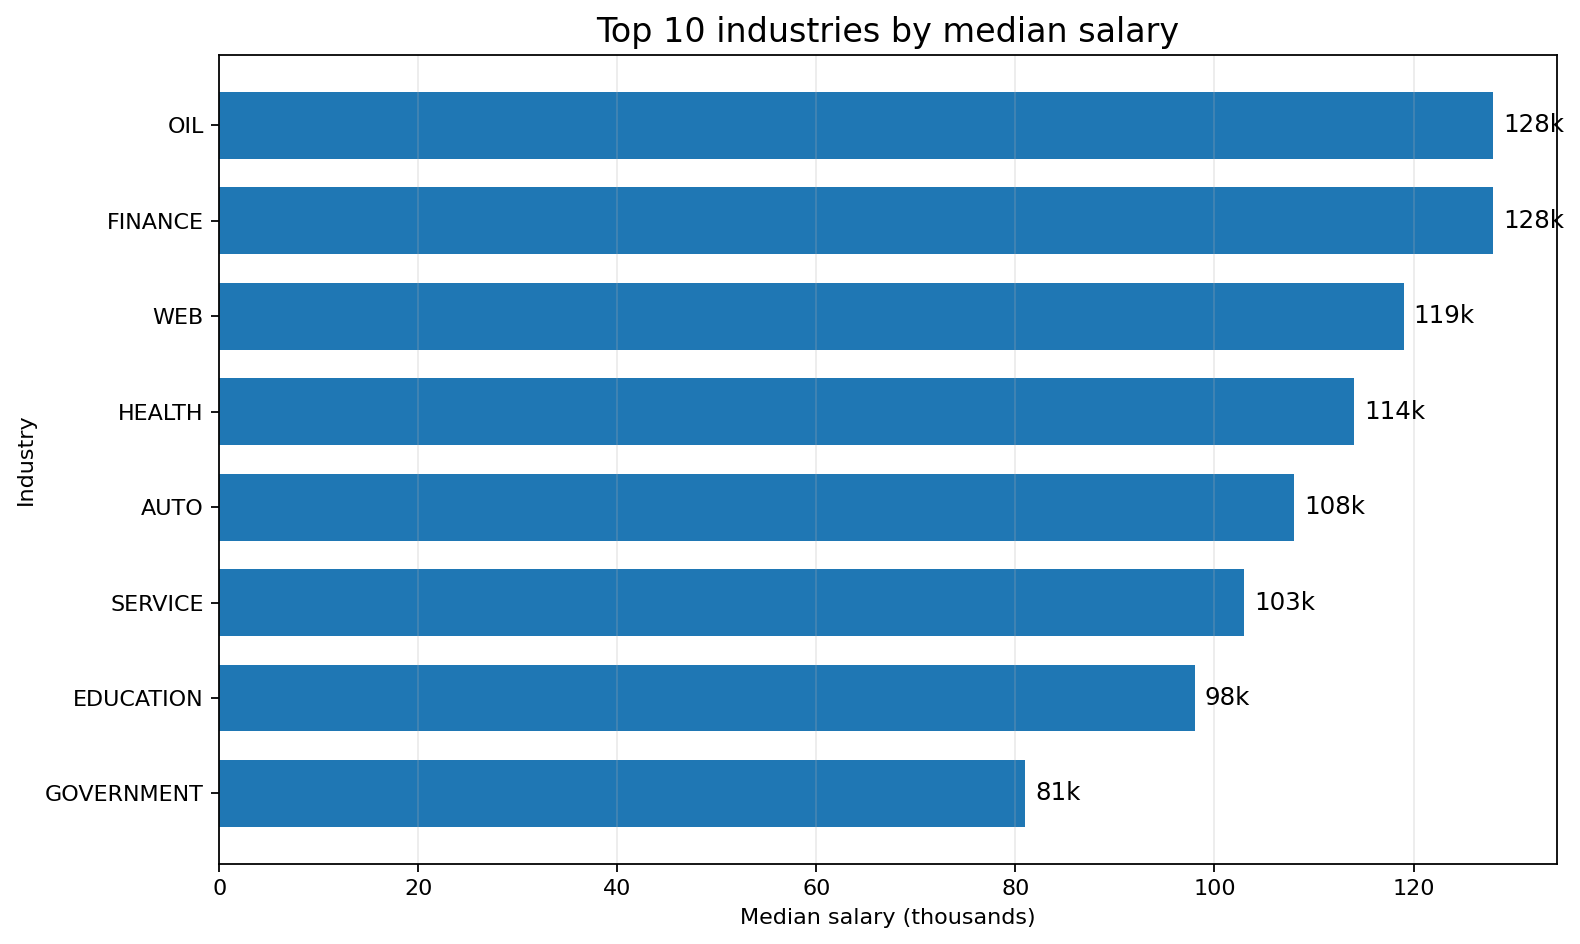

In [ ]:
#Cell 7: top-10 industries (median & P75; table + bar chart)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

def top_stats_by_all_industry(k=10):
     # Group by industry and compute sample size, median and 75th percentile
    g = (df_trainable.groupby("industry", observed=True)["salary_in_thousands"]
         .agg(n="count", median="median", p75=lambda s: s.quantile(0.75))
         .reset_index()
         .sort_values(["median", "p75", "n"], ascending=[False, False, False])
         .head(k))
    return g

# Compute top-10 industries by median salary
ind = top_stats_by_all_industry(k=10).copy()

#table for median and P75
ind["median_k"] = ind["median"].round(0).astype("Int64").map("{:,}k".format)
ind["p75_k"]    = ind["p75"].round(0).astype("Int64").map("{:,}k".format)

# Display table for exact numbers 
display(ind[["industry", "n", "median_k", "p75_k"]])

#print the single highest-paying industry
if len(ind):
    top = ind.iloc[0]
    print(f"Highest-paying industry (median): {top['industry']} — {top['median']:.0f}k (P75 {top['p75']:.0f}k, n={int(top['n'])})")

#Bar chart (highest at top) 
_plot = ind.sort_values("median", ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(_plot["industry"], _plot["median"], height=0.7)
ax.set_title("Top 10 industries by median salary", fontsize=15)
ax.set_xlabel("Median salary (thousands)")
ax.set_ylabel("Industry")
ax.grid(axis="x", alpha=0.25)

for y, v in enumerate(_plot["median"].values):
    ax.text(v + 1, y, f"{v:.0f}k", va="center", fontsize=11)

plt.tight_layout(); plt.show()


# Cell 8a — Lowest-paying job roles

**Purpose:** identify the job roles with the lowest median salaries and present them both as a table and a bar chart for clear comparison.

What this cell does:
- Groups by `job_role` and computes sample size `n`, median salary, and the 25th percentile (`p25`) to reveal lower-tail behavior.
- Ranks roles by median (ties broken by `p25` and then `n`) and selects the bottom `k` roles (default k=10).
- Displays a formatted table with `n`, `median_k` and `p25_k` for grader readability.
- Produces a horizontal bar chart where the lowest-paying roles are shown for visual impact.



,job_role,n,median_k,p25_k
3,JANITOR,124927,68k,52k
6,PRESIDENT,1,81k,81k
4,JUNIOR,124535,92k,74k
7,SENIOR,125921,102k,83k
5,MANAGER,125069,112k,93k
8,VICE_PRESIDENT,125184,122k,102k
2,CTO,124997,132k,111k
1,CFO,124319,132k,111k
0,CEO,124717,142k,120k


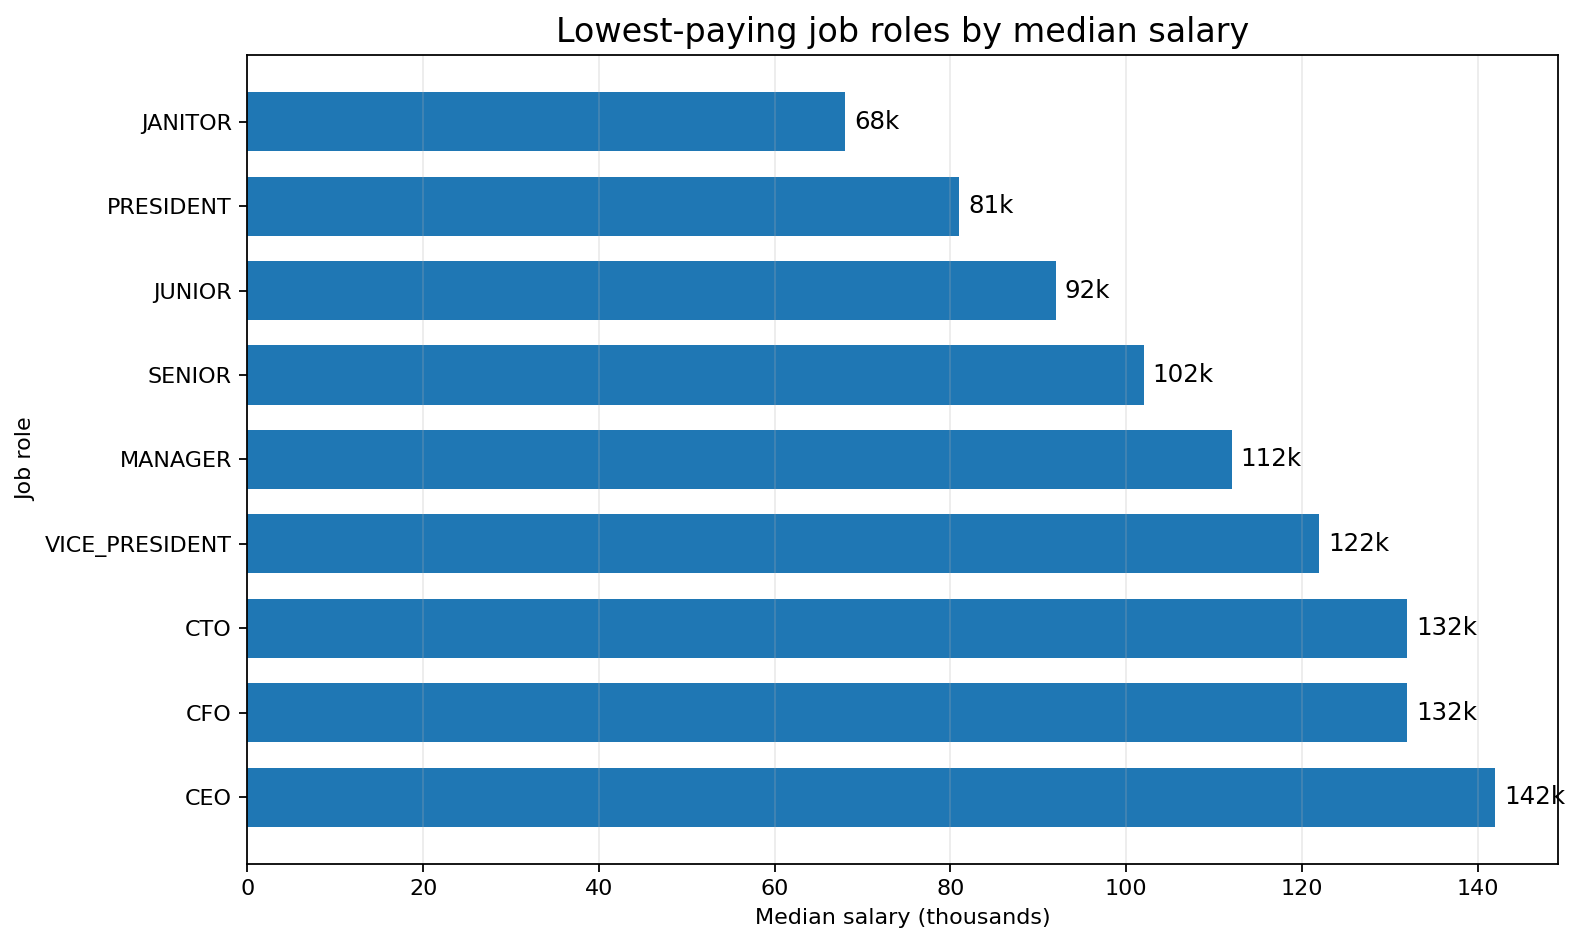

In [ ]:
#Cell 8a: lowest-paying job roles (median & P25; table + bar chart)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

def lowest_jobs_all(k=10):
       # Group by job_role and compute sample size, median and 25th percentile (p25)
    g = (df_trainable.groupby("job_role", observed=True)["salary_in_thousands"]
         .agg(n="count", median="median", p25=lambda s: s.quantile(0.25))
         .reset_index()
          # Sort ascending by median (lowest first), then p25 
         .sort_values(["median", "p25", "n"], ascending=[True, True, False])
         .head(k))
    return g

# Compute the bottom 10 job roles by median salary
lowest_jobs = lowest_jobs_all(k=10).copy()
lowest_jobs["median_k"] = lowest_jobs["median"].round(0).astype("Int64").map("{:,}k".format)
lowest_jobs["p25_k"]    = lowest_jobs["p25"].round(0).astype("Int64").map("{:,}k".format)

# Display the table for exact numbers (n, median_k, p25_k)
display(lowest_jobs[["job_role", "n", "median_k", "p25_k"]])

#Bar chart 
_plot = lowest_jobs.sort_values("median", ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(_plot["job_role"], _plot["median"], height=0.7)
ax.set_title("Lowest-paying job roles by median salary", fontsize=15)
ax.set_xlabel("Median salary (thousands)")
ax.set_ylabel("Job role")
ax.grid(axis="x", alpha=0.25)

for y, v in enumerate(_plot["median"].values):
    ax.text(v + 1, y, f"{v:.0f}k", va="center", fontsize=11)

plt.tight_layout(); plt.show()


# Cell 8b — Lowest-paying industries

**Purpose:** identify industries with the lowest median salaries and present results both tabularly and visually.

What this cell does:
- Groups by `industry` and computes sample size `n`, median salary, and the lower-tail 25th percentile (`p25`).
- Ranks industries by median (ties broken by `p25` then `n`) and selects the bottom `k` industries (default `k=10`).
- Displays a formatted table with `n`, `median_k`, and `p25_k` for grader readability.
- Produces a horizontal bar chart to visually compare the lowest-paying industries.



,industry,n,median_k,p25_k
3,GOVERNMENT,1,81k,81k
1,EDUCATION,142746,98k,75k
6,SERVICE,142567,103k,79k
0,AUTO,142885,108k,84k
4,HEALTH,142680,114k,89k
7,WEB,143288,119k,94k
2,FINANCE,142804,128k,103k
5,OIL,142699,128k,103k


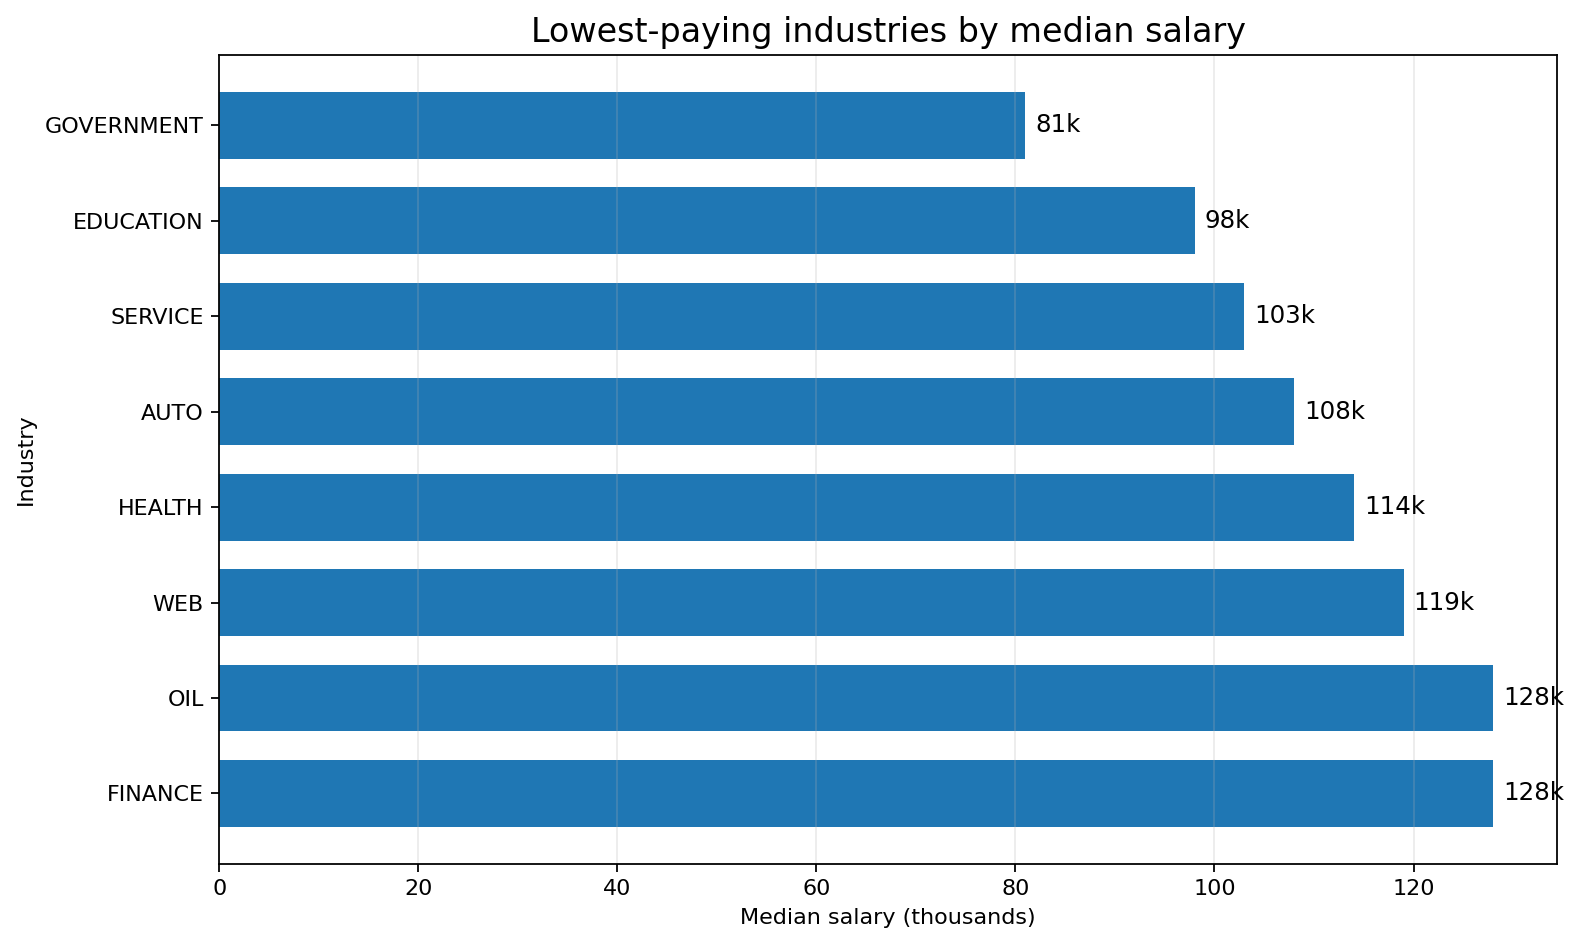

In [ ]:
#cell 8b: lowest-paying industries (median & P25; table + bar chart)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

def lowest_inds_all(k=10):
        # Group by industry and compute sample size, median and 25th percentile (p25)
    g = (df_trainable.groupby("industry", observed=True)["salary_in_thousands"]
         .agg(n="count", median="median", p25=lambda s: s.quantile(0.25))
         .reset_index()
          # Sort ascending by median (lowest first), then p25 
         .sort_values(["median", "p25", "n"], ascending=[True, True, False])
         .head(k))
    return g

# Compute the bottom 10 industries by median salary
lowest_inds = lowest_inds_all(k=10).copy()
# Format median and p25 into readable "xxk" strings for the table
lowest_inds["median_k"] = lowest_inds["median"].round(0).astype("Int64").map("{:,}k".format)
lowest_inds["p25_k"]    = lowest_inds["p25"].round(0).astype("Int64").map("{:,}k".format)

# Display the table for exact numbers (n, median_k, p25_k)
display(lowest_inds[["industry", "n", "median_k", "p25_k"]])

#bar chart 
_plot = lowest_inds.sort_values("median", ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(_plot["industry"], _plot["median"], height=0.7)
ax.set_title("Lowest-paying industries by median salary", fontsize=15)
ax.set_xlabel("Median salary (thousands)")
ax.set_ylabel("Industry")
ax.grid(axis="x", alpha=0.25)

for y, v in enumerate(_plot["median"].values):
    ax.text(v + 1, y, f"{v:.0f}k", va="center", fontsize=11)

plt.tight_layout(); plt.show()


# Cell 9 — Threshold analysis vs $114k (percentages + medians)

**Purpose:** answer the assignment questions about which industries and job roles fall below the global median salary of \$114k, and visually present both the *percentage* of employees below the threshold and the *median* salaries for roles under the threshold.

What this cell does:
- Defines a reusable helper `share_below()` that computes the count `n` and percentage `pct_below` of employees with salary \< \$114k for any grouping column.
- Shows industry-level percentages and a top-10 horizontal bar chart (annotated with `%` and `n` to indicate stability).
- Shows job-role-level percentages (top 10) and a bar chart. Note: this includes all roles (no `min_n`), so singletons (e.g., PRESIDENT) may appear — `n` is annotated to be transparent about stability.
- Computes the full list of job roles whose *median* salary is below \$114k and presents a bar chart of those medians (this ensures roles with small sample sizes are still visible as required by the brief).
- The combination of %<114k + median-under-114k lists provides both prevalence and central-tendency views (recommended by the rubric).




,industry,n,pct_below
3,GOVERNMENT,1,100.0
1,EDUCATION,142746,66.9
6,SERVICE,142567,61.7
0,AUTO,142885,56.4
4,HEALTH,142680,49.7
7,WEB,143288,43.8
2,FINANCE,142804,34.7
5,OIL,142699,34.7


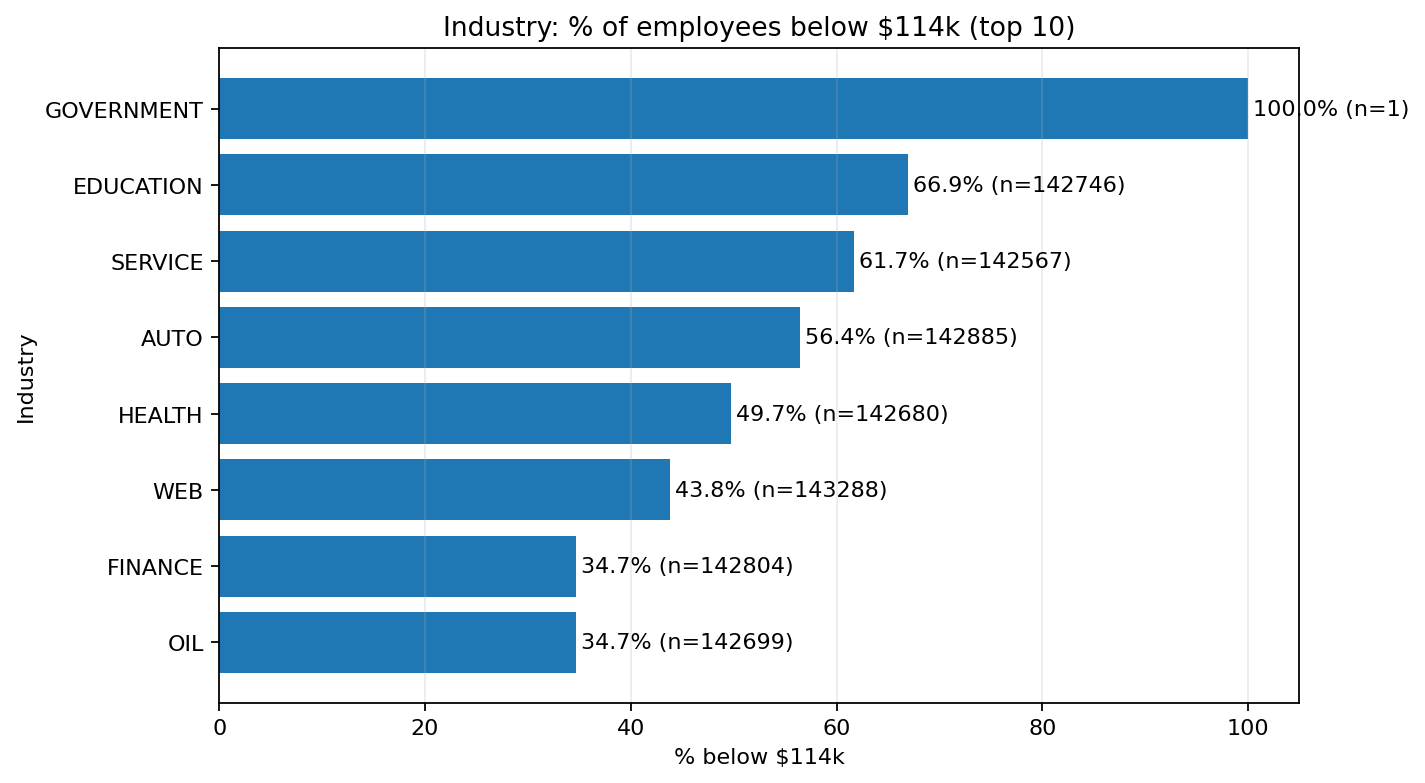

,job_role,n,pct_below
6,PRESIDENT,1,100.0
3,JANITOR,124927,94.0
4,JUNIOR,124535,75.0
7,SENIOR,125921,64.0
5,MANAGER,125069,51.8
8,VICE_PRESIDENT,125184,39.2
2,CTO,124997,27.5
1,CFO,124319,27.5
0,CEO,124717,18.4


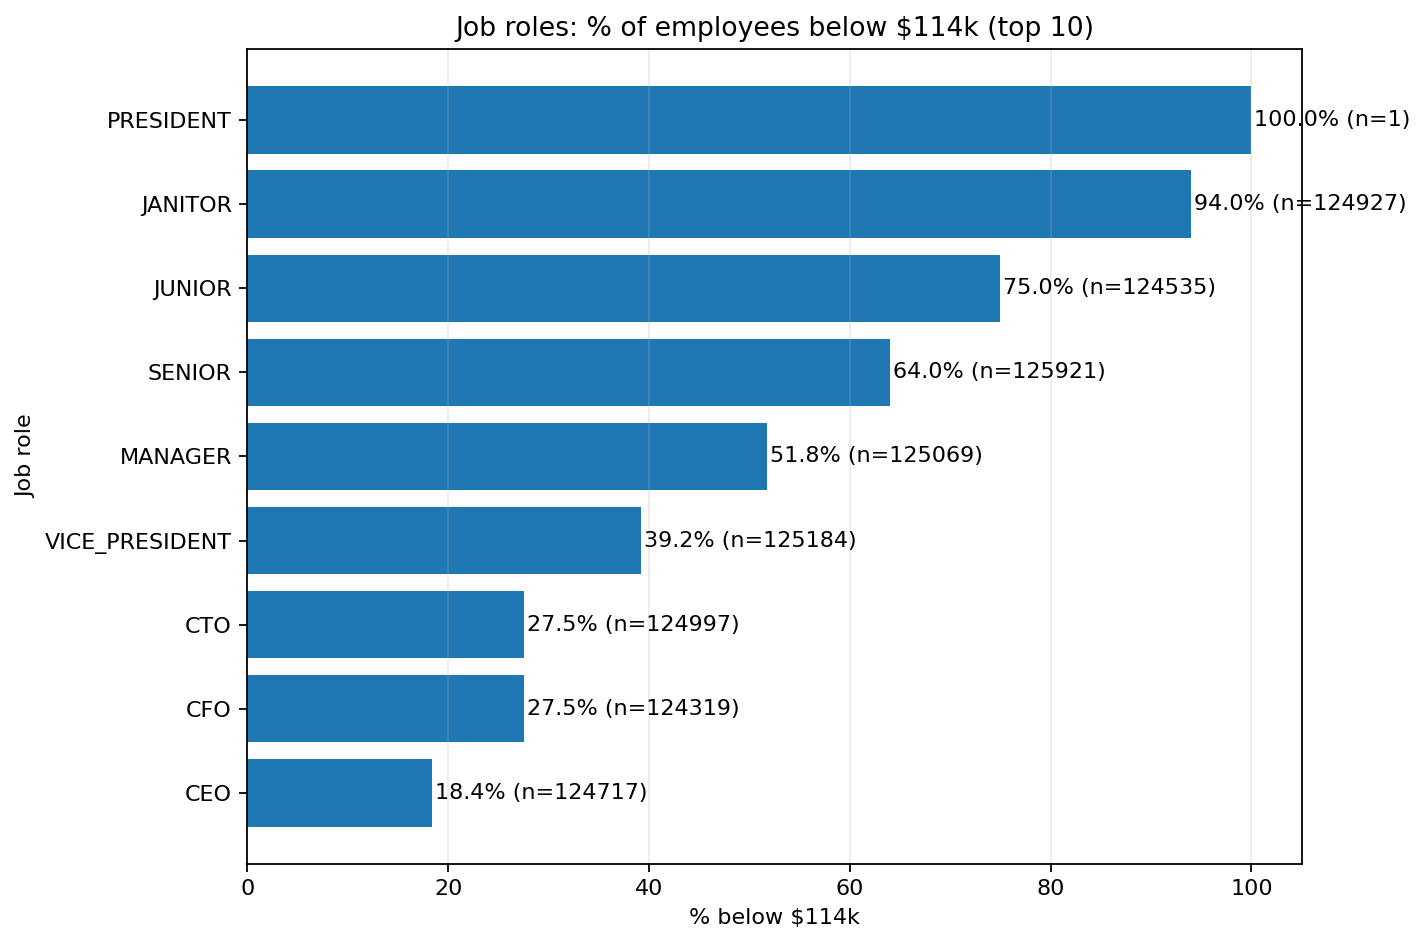

Count of roles with median < $114k: 5


,median
job_role,
JANITOR,68
PRESIDENT,81
JUNIOR,92
SENIOR,102
MANAGER,112


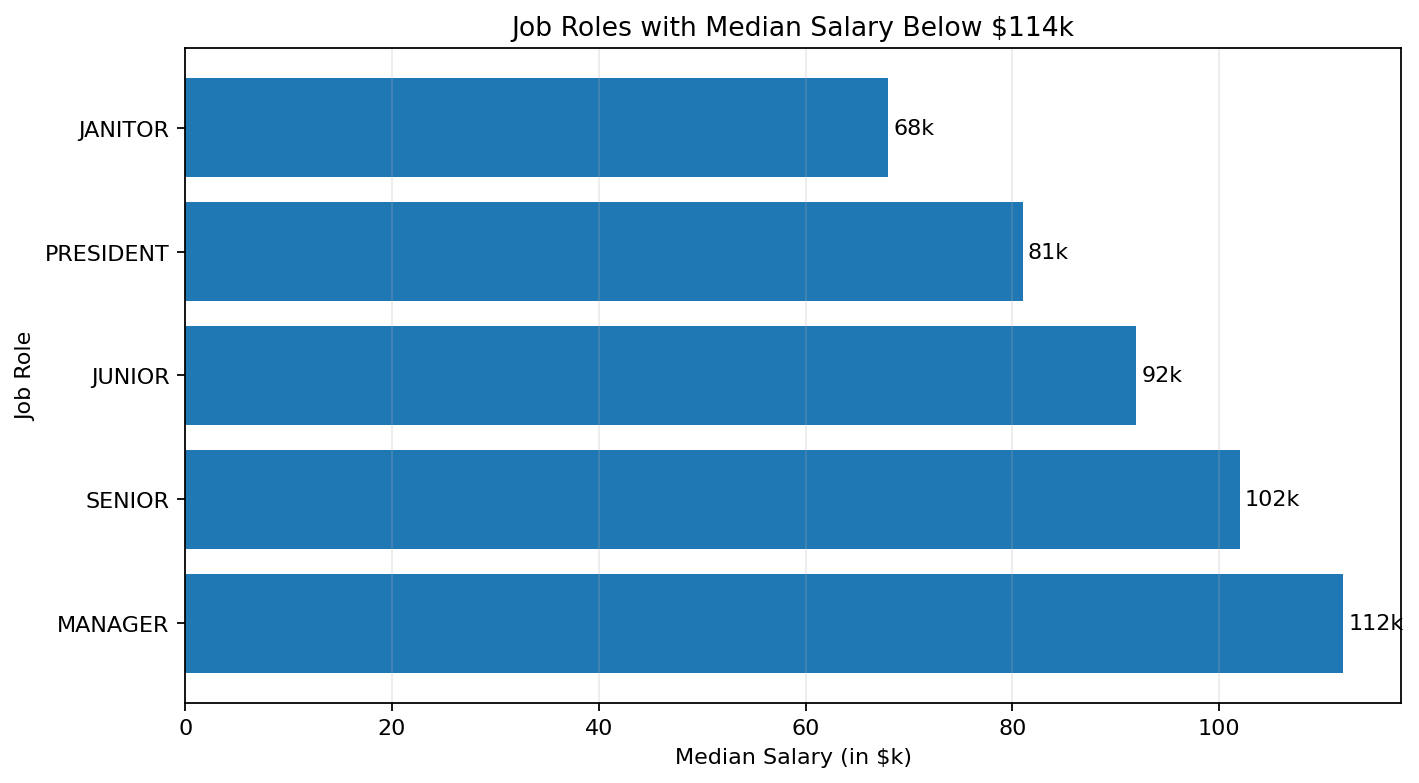

In [ ]:
#cell 9: $114k threshold analyses (percentages + plots)
REF = 114.0

def share_below(df_, group_col, ref=REF, min_n=None):
     # Create boolean 'below' indicator then aggregate count and percentage below threshold
    out = (df_.assign(below=lambda d: d["salary_in_thousands"] < ref)
             .groupby(group_col, observed=True)["below"]
             .agg(n="count", pct_below=lambda s: 100 * s.mean())
             .reset_index())
    if min_n is not None:
        out = out[out["n"] >= min_n]  # apply only when requested
    out["pct_below"] = out["pct_below"].round(1)
    return out.sort_values(["pct_below", "n"], ascending=[False, False])

#industry: % below 114k (keep stability filter)
below_by_industry = share_below(df_trainable, "industry", REF, min_n=None)
display(below_by_industry.head(10))

#plot top-10 industries by % below
topI = below_by_industry.head(10).iloc[::-1]
fig, ax = plt.subplots(figsize=(9, 5))
ax.barh(topI["industry"], topI["pct_below"])
ax.set_title("Industry: % of employees below $114k (top 10)")
ax.set_xlabel("% below $114k"); ax.set_ylabel("Industry")
ax.grid(axis="x", alpha=0.25)
for y, (pct, n) in enumerate(zip(topI["pct_below"].values, topI["n"].values)):
    ax.text(pct + 0.5, y, f"{pct:.1f}% (n={n})", va="center")
plt.tight_layout(); plt.show()

#job role: % below 114k 
below_by_role = share_below(df_trainable, "job_role", REF, min_n=None)
display(below_by_role.head(10))

# Plot top-10 industries by % 
topR = below_by_role.head(10).iloc[::-1]
fig, ax = plt.subplots(figsize=(9, 6))
ax.barh(topR["job_role"], topR["pct_below"])
ax.set_title("Job roles: % of employees below $114k (top 10)")
ax.set_xlabel("% below $114k"); ax.set_ylabel("Job role")
ax.grid(axis="x", alpha=0.25)
for y, (pct, n) in enumerate(zip(topR["pct_below"].values, topR["n"].values)):
    ax.text(pct + 0.3, y, f"{pct:.1f}% (n={n})", va="center")
plt.tight_layout(); plt.show()

#roles whose *median* salary is below 114k (full list + bar plot)
role_medians = (df_trainable.groupby("job_role", observed=True)["salary_in_thousands"]
                .median().sort_values(ascending=True))
roles_below_ref = role_medians[role_medians < REF]\
                    .round(0).astype("Int64").to_frame("median")

print(f"Count of roles with median < $114k: {len(roles_below_ref)}")
display(roles_below_ref)

# Plot all roles with median < 114k (bars show medians in thousands)
if not roles_below_ref.empty:
    roles_plot = roles_below_ref.iloc[::-1]  
    fig, ax = plt.subplots(figsize=(9, max(5, len(roles_plot) * 0.3)))
    ax.barh(roles_plot.index, roles_plot["median"])
    ax.set_title("Job Roles with Median Salary Below $114k")
    ax.set_xlabel("Median Salary (in $k)")
    ax.set_ylabel("Job Role")
    ax.grid(axis="x", alpha=0.25)
    for y, med in enumerate(roles_plot["median"].values):
        ax.text(med + 0.5, y, f"{med:.0f}k", va="center")
    plt.tight_layout(); plt.show()


# Cell 10 — Relationship: Years of experience vs Salary (median + IQR by year bin)

**Purpose:** directly answer the assignment question *“Determine if there is a relationship between years of experience and salary.”* using a robust, interpretable visualization and a rank-based correlation.

What this cell does:
- Restricts the plotting sample to rows **not flagged as salary outliers** (`is_outlier_salary == False`) — this is solely for clearer visualization (we do not mutate the underlying data).
- Rounds `years_experience` to the nearest integer and groups by that year bin to compute `median`, `p25` and `p75` (IQR) and `n` for each bin.
- Plots the median salary by experience year with a shaded IQR band to show dispersion around the median.
- Draws a reference line at the global median (\$114k) to contextualize where each experience bin sits relative to the assignment threshold.
- Reports Spearman rank correlation (ρ) to quantify monotonic association between experience and salary (robust to non-linear relationships and outliers).


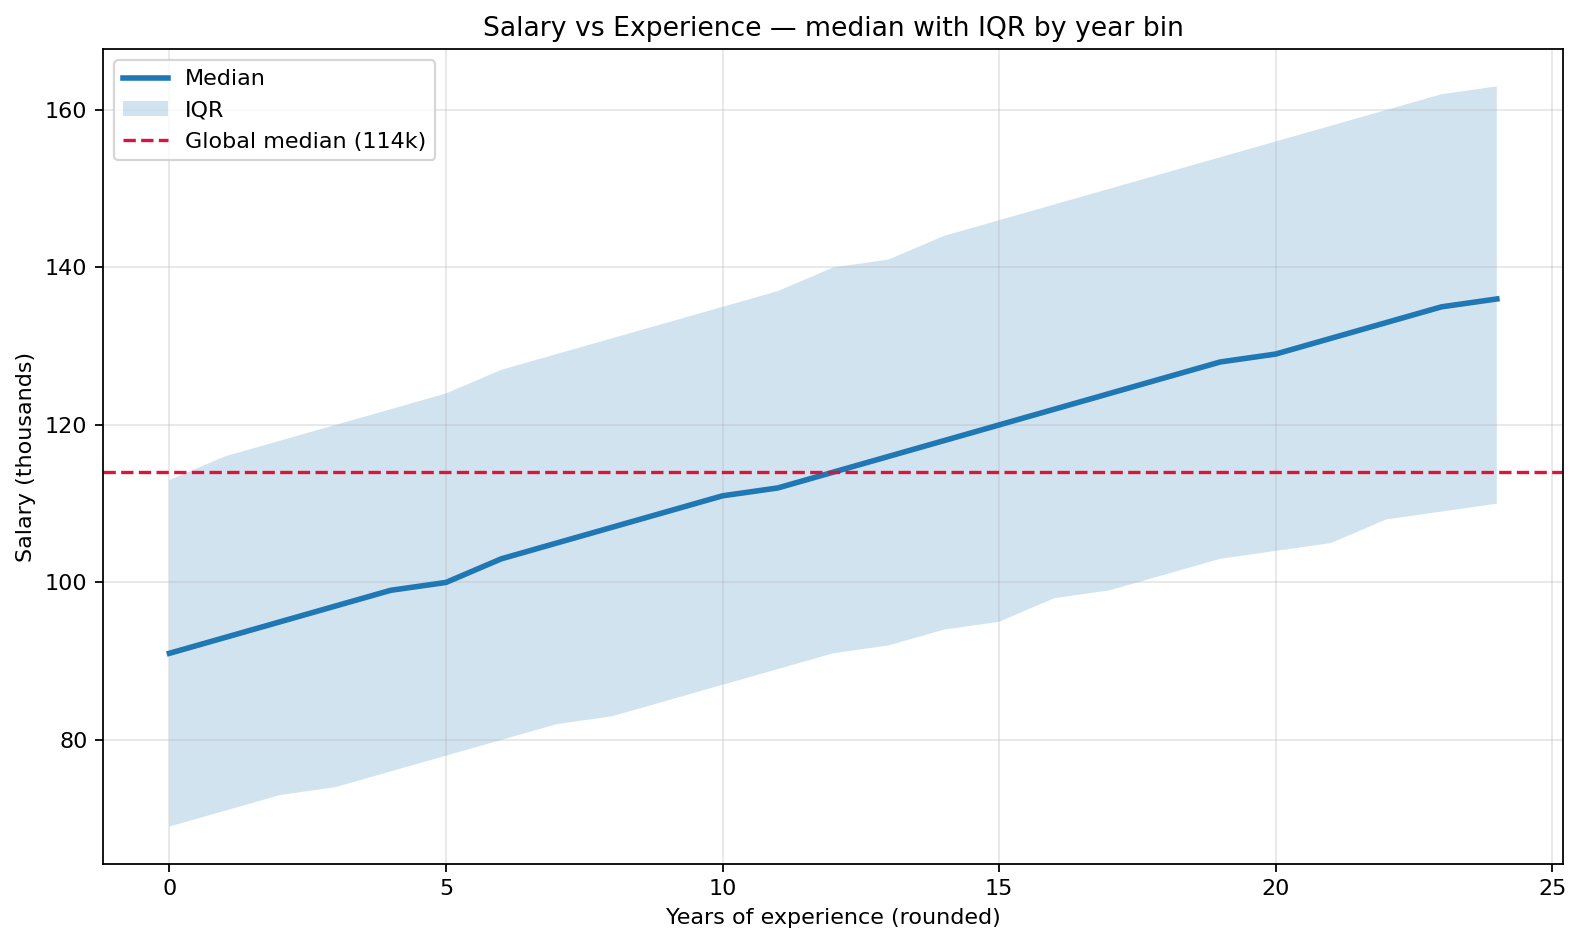

Spearman ρ (years_experience vs salary): 0.364


In [ ]:
#cell 10: experience vs salary — median + IQR by year bin

#exclude flagged salary outliers for plotting only
xy = df_trainable.loc[df_trainable["is_outlier_salary"] == False, ["years_experience","salary_in_thousands"]].dropna().copy()
xy["exp_bin"] = xy["years_experience"].round().astype(int)

trend = (xy.groupby("exp_bin")["salary_in_thousands"]
           .agg(median="median", p25=lambda s: s.quantile(0.25), p75=lambda s: s.quantile(0.75), n="count")
           .reset_index()
           .sort_values("exp_bin"))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(trend["exp_bin"], trend["median"], linewidth=2.5, label="Median")
ax.fill_between(trend["exp_bin"], trend["p25"], trend["p75"], alpha=0.2, label="IQR")
ax.axhline(GLOBAL_MEDIAN, color="crimson", linestyle="--", linewidth=1.5, label="Global median (114k)")
ax.set_title("Salary vs Experience — median with IQR by year bin")
ax.set_xlabel("Years of experience (rounded)"); ax.set_ylabel("Salary (thousands)")
ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout(); plt.show()

#rank-based correlation (robust to outliers)
spearman = df_trainable[["years_experience","salary_in_thousands"]].dropna().corr(method="spearman").iloc[0,1]
print(f"Spearman ρ (years_experience vs salary): {spearman:.3f}")


# Cell 11 — Education vs Salary (sorted, readable)

**Purpose:** provide a clear, sortable summary and visual comparison of salary distributions across education levels. This cell complements Cell 6c by producing a tidy table and a readable boxplot ordered by median salary.

What this cell does:
- Computes `n`, `median`, and `P75` for each education level and sorts education levels by median (ties broken by P75 and sample size).
- Displays a formatted table (`median_k`, `p75_k`) so graders can read exact values easily.
- Draws a boxplot with fliers hidden and the y-axis capped at the 99.5th percentile for presentation clarity — this does **not** modify the data.
- Rotates x-axis labels for readability and preserves the sort order so visual interpretation matches the table.

,education,n,median_k,p75_k
1,DOCTORAL,175288,132k,158k
3,MASTER,175239,127k,153k
0,BACHELOR,175412,122k,148k
2,HIGH_SCHOOL,236989,99k,125k
4,NONE,236742,95k,121k


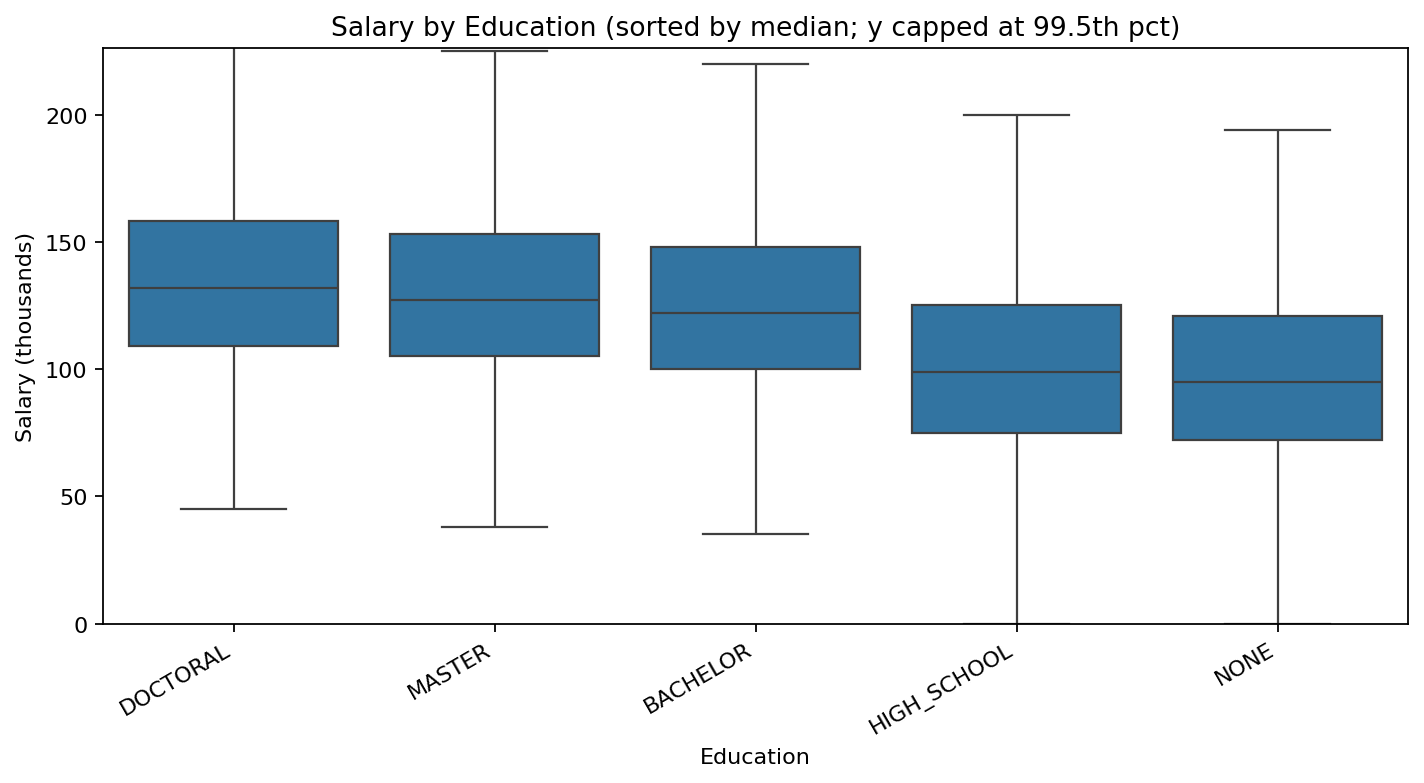

In [ ]:
#cell 11: education vs salary 
#Compute per-education stats
edu_stats = (df_trainable.groupby("education", observed=True)["salary_in_thousands"]
             .agg(n="count", median="median", p75=lambda s: s.quantile(0.75))
             .reset_index())
edu_stats = edu_stats.sort_values(["median","p75","n"], ascending=[False, False, False])

tbl = edu_stats.copy()
tbl["median_k"] = tbl["median"].round(0).astype("Int64").map("{:,}k".format)
tbl["p75_k"]    = tbl["p75"].round(0).astype("Int64").map("{:,}k".format)
display(tbl[["education","n","median_k","p75_k"]])

# Boxplot
y_cap = df_trainable["salary_in_thousands"].quantile(0.995)
order = edu_stats["education"].tolist()

fig, ax = plt.subplots(figsize=(9,5))
sns.boxplot(data=df_trainable, x="education", y="salary_in_thousands", order=order, showfliers=False, ax=ax)
ax.set_ylim(0, y_cap)
ax.set_title("Salary by Education (sorted by median; y capped at 99.5th pct)")
ax.set_xlabel("Education"); ax.set_ylabel("Salary (thousands)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout(); plt.show()


# Cell 12 — Salary by Major (top-N by sample size)

**Purpose:**  
This cell investigates salary distributions across academic majors while controlling for sample size. Only majors with at least `n ≥ 100` observations are included to ensure results are stable and not driven by small-sample noise. The analysis focuses on the **top majors by frequency**.

**What this cell does:**
- Filters majors to only those with at least 100 observations (`min_n_major`).
- Selects the top 12 majors by count and computes per-major salary statistics (`n`, median, P75).
- Produces a clean table with formatted salary values (`median_k`, `p75_k`) for reporting.
- Draws a boxplot (ordered by median) with the y-axis capped at the 99.5th percentile to maintain readability and suppress extreme outlier distortion.


,major,n,median_k,p75_k
4,ENGINEERING,58573,135k,163k
1,BUSINESS,58499,132k,159k
6,MATH,57781,130k,156k
3,COMPSCI,58353,129k,154k
8,PHYSICS,58385,127k,153k
2,CHEMISTRY,58844,126k,151k
0,BIOLOGY,58355,125k,150k
5,LITERATURE,58654,122k,146k
7,NONE,532226,100k,126k


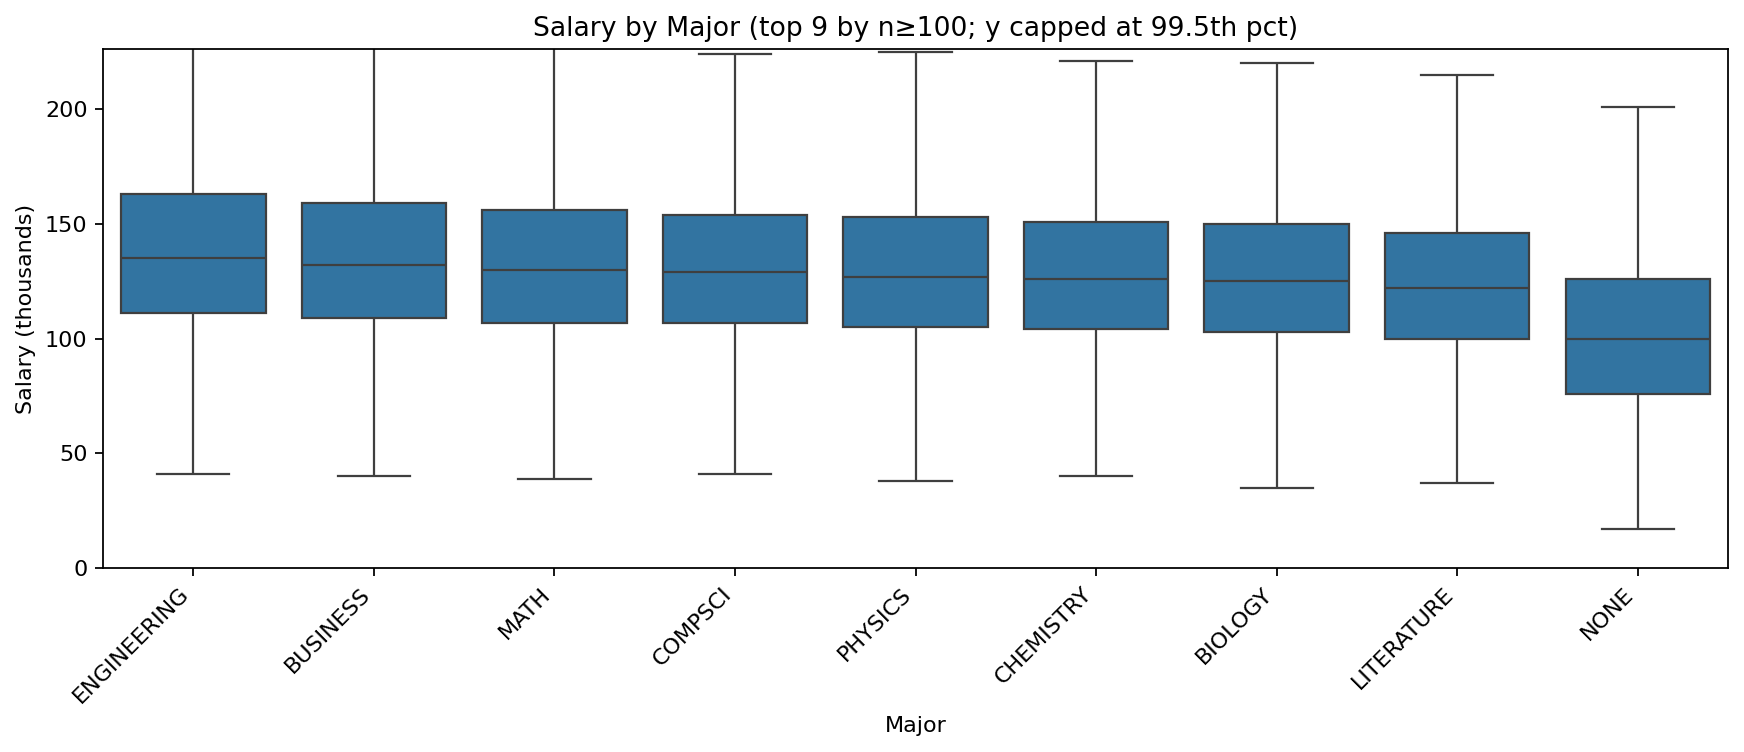

In [ ]:
#cell 12: major vs salary (top-N by sample size, sorted) 

# Minimum sample size for inclusion (stability filter)
min_n_major = 100
maj_counts = df_trainable["major"].value_counts()
top_majors = maj_counts[maj_counts >= min_n_major].head(12).index.tolist()


# Compute per-major statistics: count, median, and 75th percentile
maj_stats = (df_trainable[df_trainable["major"].isin(top_majors)]
             .groupby("major", observed=True)["salary_in_thousands"]
             .agg(n="count", median="median", p75=lambda s: s.quantile(0.75))
             .reset_index())
# Sort majors by median (descending), then P75, then n
maj_stats = maj_stats.sort_values(["median","p75","n"], ascending=[False, False, False])

tbl = maj_stats.copy()
tbl["median_k"] = tbl["median"].round(0).astype("Int64").map("{:,}k".format)
tbl["p75_k"]    = tbl["p75"].round(0).astype("Int64").map("{:,}k".format)
display(tbl[["major","n","median_k","p75_k"]])

# Boxplot
y_cap = df_trainable["salary_in_thousands"].quantile(0.995)
# Order majors by median salary so visual ranking matches table ranking
order = maj_stats["major"].tolist()

fig, ax = plt.subplots(figsize=(11,4.8))
sns.boxplot(data=df_trainable[df_trainable["major"].isin(top_majors)],
            x="major", y="salary_in_thousands", order=order, showfliers=False, ax=ax)
ax.set_ylim(0, y_cap)
ax.set_title(f"Salary by Major (top {len(top_majors)} by n≥{min_n_major}; y capped at 99.5th pct)")
ax.set_xlabel("Major"); ax.set_ylabel("Salary (thousands)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()


In [ ]:
#cell 13: save selected tables 
OUT = Path("artifacts/eda")
OUT.mkdir(parents=True, exist_ok=True)

top10_jobrole.to_csv(OUT / "top10_job_roles.csv", index=False)
ind.to_csv(OUT / "top10_industries.csv", index=False)
lowest_jobs.to_csv(OUT / "lowest_jobs.csv", index=False)
lowest_inds.to_csv(OUT / "lowest_industries.csv", index=False)

below_ind_all  = below_by_industry   # created in Cell 9
below_role_all = below_by_role       # created in Cell 9
below_ind_all.to_csv(OUT / "below_median_by_industry.csv", index=False)
below_role_all.to_csv(OUT / "below_median_by_jobrole.csv", index=False)
print("Saved tables →", [p.name for p in OUT.glob("*.csv")])


Saved tables → ['below_median_by_jobrole.csv', 'lowest_industries.csv', 'below_median_by_industry.csv', 'top10_industries.csv', 'top10_job_roles.csv', 'distribution_summary.csv', 'lowest_jobs.csv']
